# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from time import time

In [18]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data['DateCrawled'].max()

'2016-04-07 14:36:58'

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<div class='alert alert-success'> ✔️Отлично, первичный анализ проведен с применением диагностических инструментов Pandas,тут можно добавить первые вывод.
</div>

In [7]:
data.fillna('unknown', inplace=True)

<div class='alert alert-success'> ✔️Ок, пропуски заполняем новой категорией. Отмечу, что в колонках типа кузова, модели, типа топлива есть значение 'other', которое можно было объединить с новой категорией (например, заполнять значением other)
</div>

<AxesSubplot:>

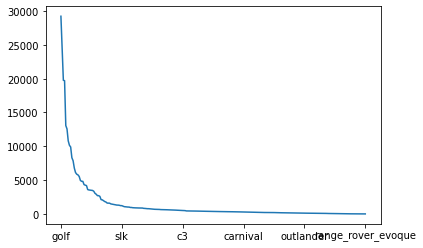

In [8]:
data['Model'].value_counts().plot()

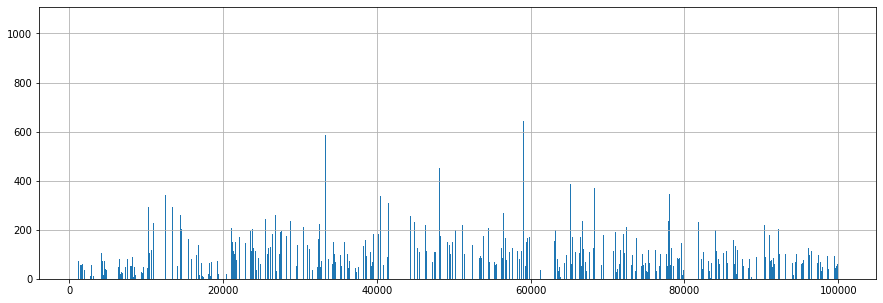

In [9]:
data['PostalCode'].hist(bins=len(data['PostalCode'].unique()), figsize=(15, 5))
plt.show()

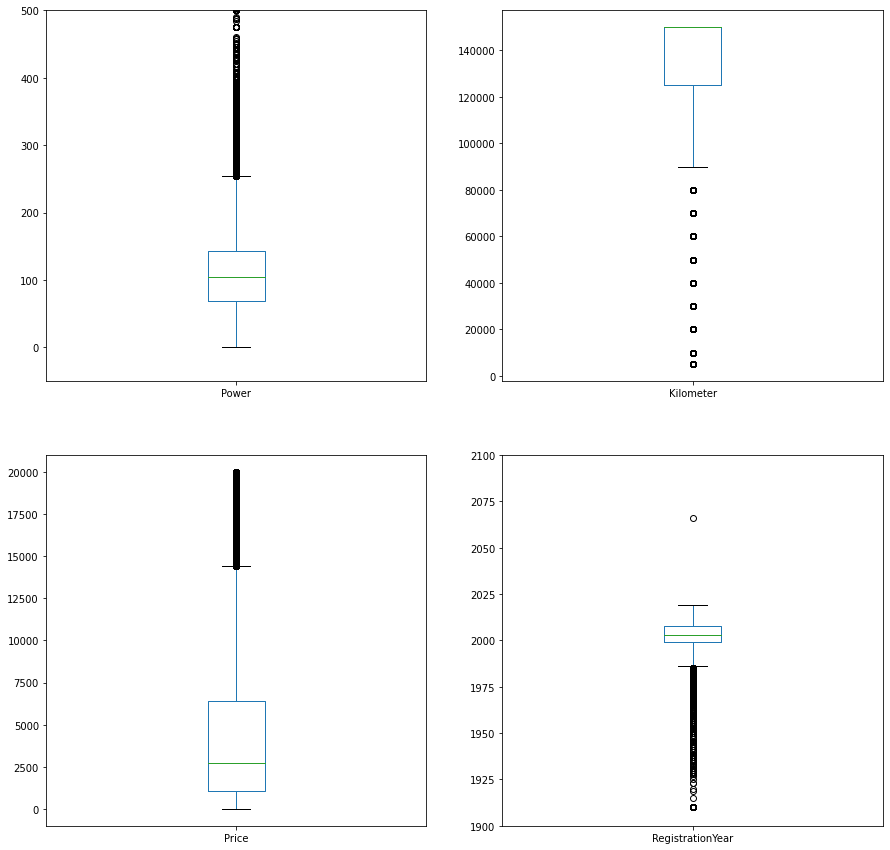

In [10]:
fig0, axs0 = plt.subplots(2, 2, figsize=(15,15))
data['Power'].plot(kind='box', ylim=(-50, 500), ax=axs0[0,0])
data['Kilometer'].plot(kind='box', ax=axs0[0,1])
data['Price'].plot(kind='box', ax=axs0[1,0])
data['RegistrationYear'].plot(kind='box', ax=axs0[1,1])
plt.ylim(1900,2100)
plt.show()



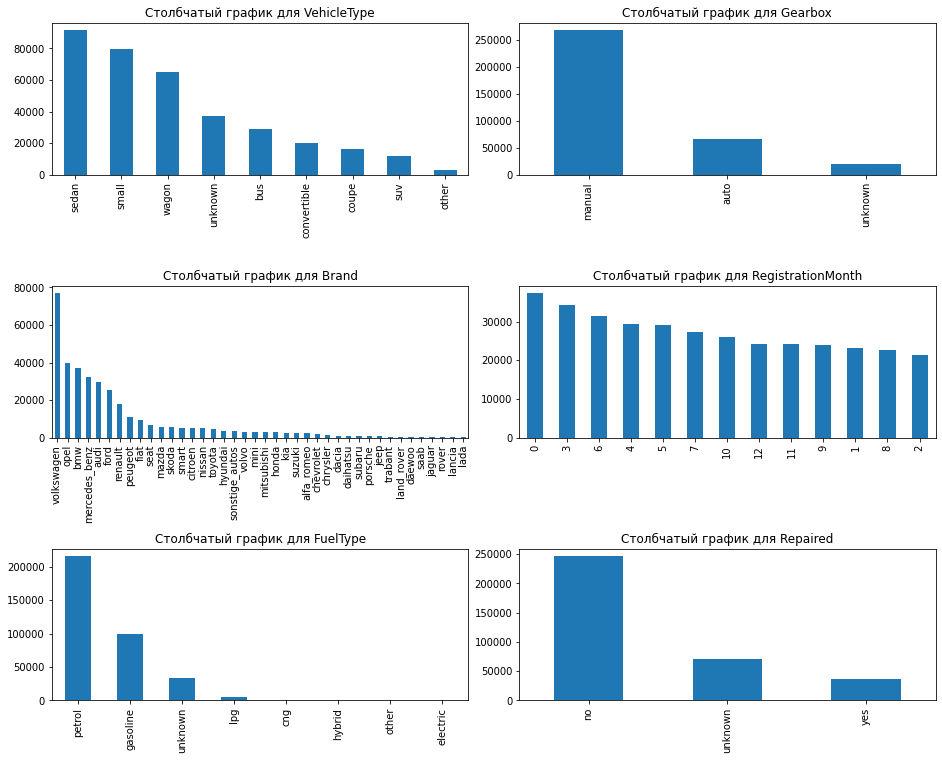

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(13,10))
fig.tight_layout(h_pad=9, w_pad=2)
columns_bar = ['VehicleType', 'Gearbox', 'Brand', 'RegistrationMonth', 'FuelType', 'Repaired']
for col, place_1, place_2 in zip(columns_bar, [0, 0, 1, 1, 2, 2], [0, 1, 0, 1, 0, 1]):
    data[col].value_counts().plot(title=f'Столбчатый график для {col}', kind='bar', ax=axs[place_1, place_2])
plt.show()

In [12]:
data['NumberOfPictures'].unique()

array([0])

**Удаление некоторых столбцов и аномалий**

In [13]:
data.drop(['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode',
          'RegistrationMonth', 'VehicleType', 'Gearbox'], axis=1, inplace=True)

In [14]:
data = data.query('Power<300 and Kilometer>70000 and Price<15000 and 1980<RegistrationYear<2023')

## Обучение моделей

In [15]:
data_ohe = pd.get_dummies(data, columns=['Model', 'FuelType', 'Brand', 'Repaired'],  drop_first=True)

In [16]:
features_train, features_valid, target_train, target_valid = train_test_split(
    data_ohe.drop('Price', axis=1), data_ohe.Price, test_size=0.25, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,
                                                                           random_state=12345)

**Модель LGBMRegressor**

In [17]:
def model_lgbm(m_d, l_r):
    model = LGBMRegressor(max_depth=m_d,  learning_rate=l_r, random_state=12345)
    start_f = time()
    model.fit(features_train, target_train)
    end_f = time()
    start_p = time()
    prediction = model.predict(features_valid)
    end_p = time()
    result = np.sqrt(mean_squared_error(target_valid, prediction))
    return 'LGBMRegressor', end_f-start_f, end_p-start_p, result, f'max_depth = {m_d}, learning_rate = {l_r}'

In [18]:
final = []

In [19]:
for m_d in tqdm([10, 40, 60]):
    for l_r in tqdm([0.3, 0.6, 0.9]):
        final.append(model_lgbm(m_d, l_r))

100%|██████████| 3/3 [01:24<00:00, 28.05s/it]


**Модель CatBoostRegressor**

In [21]:
def model_cb(l_r, it):
    model = CatBoostRegressor(learning_rate=l_r, iterations=it, random_state=12345)
    start_f = time()
    model.fit(features_train, target_train)
    end_f = time()
    start_p = time()
    prediction = model.predict(features_valid)
    end_p = time()
    result = np.sqrt(mean_squared_error(target_valid, prediction))
    return 'CatBoostRegressor', end_f-start_f, end_p-start_p, result, f'learning_rate = {l_r}, iterations={it}'

In [ ]:
for l_r in tqdm([0.3, 0.6, 0.9]):
    for it in tqdm([10, 50, 70]):
        final.append(model_cb(l_r, it))

**Модель DecisionTreeRegressor**

In [23]:
def model_dt(m_d):
    model = DecisionTreeRegressor(max_depth=m_d, random_state=12345)
    start_f = time()
    model.fit(features_train, target_train)
    end_f = time()
    start_p = time()
    prediction = model.predict(features_valid)
    end_p = time()
    result = np.sqrt(mean_squared_error(target_valid, prediction))
    return 'DecisionTreeRegressor', end_f-start_f, end_p-start_p, result, f'max_depth = {m_d}'

In [24]:
for m_d in tqdm(range(10, 130)):
    final.append(model_dt(m_d))

100%|██████████| 120/120 [18:32<00:00,  9.27s/it]


**Получение таблицы с результатами**

In [25]:
final_table = pd.DataFrame({'model_name':[final[i][0] for i in range(len(final))],
                            'parameters':[final[i][4] for i in range(len(final))], 
                            'time_fit':[final[i][1] for i in range(len(final))], 
                            'time_pr':[final[i][2] for i in range(len(final))], 
                            'RMSE':[final[i][3] for i in range(len(final))]})

In [26]:
final_table.loc[final_table.loc[final_table['model_name']=='DecisionTreeRegressor'].\
                 sort_values('RMSE')[:9].index.to_list() + final_table.\
                loc[final_table['model_name']=='LGBMRegressor'].index.to_list() +
               final_table.loc[final_table['model_name']=='CatBoostRegressor'].index.to_list()].\
sort_values('RMSE').reset_index(drop=True)

,model_name,parameters,time_fit,time_pr,RMSE
0,LGBMRegressor,"max_depth = 40, learning_rate = 0.6",6.380244,0.311653,1444.097098
1,LGBMRegressor,"max_depth = 60, learning_rate = 0.6",6.299512,0.308246,1444.097098
2,LGBMRegressor,"max_depth = 10, learning_rate = 0.6",6.300553,0.397629,1449.580701
3,LGBMRegressor,"max_depth = 60, learning_rate = 0.9",7.089885,0.305600,1456.078597
4,LGBMRegressor,"max_depth = 40, learning_rate = 0.9",6.807316,0.396496,1456.078597
5,LGBMRegressor,"max_depth = 10, learning_rate = 0.3",6.347635,0.400183,1459.036156
6,LGBMRegressor,"max_depth = 60, learning_rate = 0.3",27.388035,0.311705,1459.246233
7,LGBMRegressor,"max_depth = 40, learning_rate = 0.3",7.696420,0.408783,1459.246233
8,LGBMRegressor,"max_depth = 10, learning_rate = 0.9",6.407318,0.388375,1459.338520
9,CatBoostRegressor,"learning_rate = 0.9, iterations=70",4.286844,0.049617,1487.082476


**С лучшим результатом RMSE=1444.097098 вышла модель LGBMRegressor со значениями learning_rate=0.6, max_depth=40**

## Анализ моделей

In [27]:
model_test = LGBMRegressor(learning_rate=0.6, max_depth=40, random_state=12345)
model_test.fit(features_train, target_train)
prediction_test = model_test.predict(features_test)
result_test = np.sqrt(mean_squared_error(target_test, prediction_test))
print('RMSE лучшей модели на тестовой выборке:', round(result_test, 5))

RMSE лучшей модели на тестовой выборке: 1448.62342
